In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### **Explatory Data Analysis**

In [96]:
import pandas as pd

df = pd.read_csv("bodyPerformance.csv")

df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
count,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000
mean,36.775106,168.559807,67.447316,23.240165,78.796842,130.234817,36.963877,15.209268,39.771224,190.129627
std,13.625639,8.426583,11.949666,7.256844,10.742033,14.713954,10.624864,8.456677,14.276698,39.868000
min,21.000000,125.000000,26.300000,3.000000,0.000000,0.000000,0.000000,-25.000000,0.000000,0.000000
25%,25.000000,162.400000,58.200000,18.000000,71.000000,120.000000,27.500000,10.900000,30.000000,162.000000
50%,32.000000,169.200000,67.400000,22.800000,79.000000,130.000000,37.900000,16.200000,41.000000,193.000000
75%,48.000000,174.800000,75.300000,28.000000,86.000000,141.000000,45.200000,20.700000,50.000000,221.000000
max,64.000000,193.800000,138.100000,78.400000,156.200000,201.000000,70.500000,213.000000,80.000000,303.000000


Check Missing Value

In [97]:
df.isnull().sum()

,0
age,0
gender,0
height_cm,0
weight_kg,0
body fat_%,0
diastolic,0
systolic,0
gripForce,0
sit and bend forward_cm,0
sit-ups counts,0


Check Distribution of Target

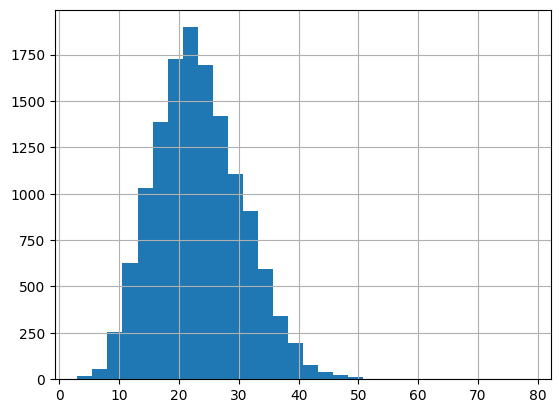

In [98]:
df['body fat_%'].hist(bins=30)
plt.show()

Check Outlier

<Axes: >

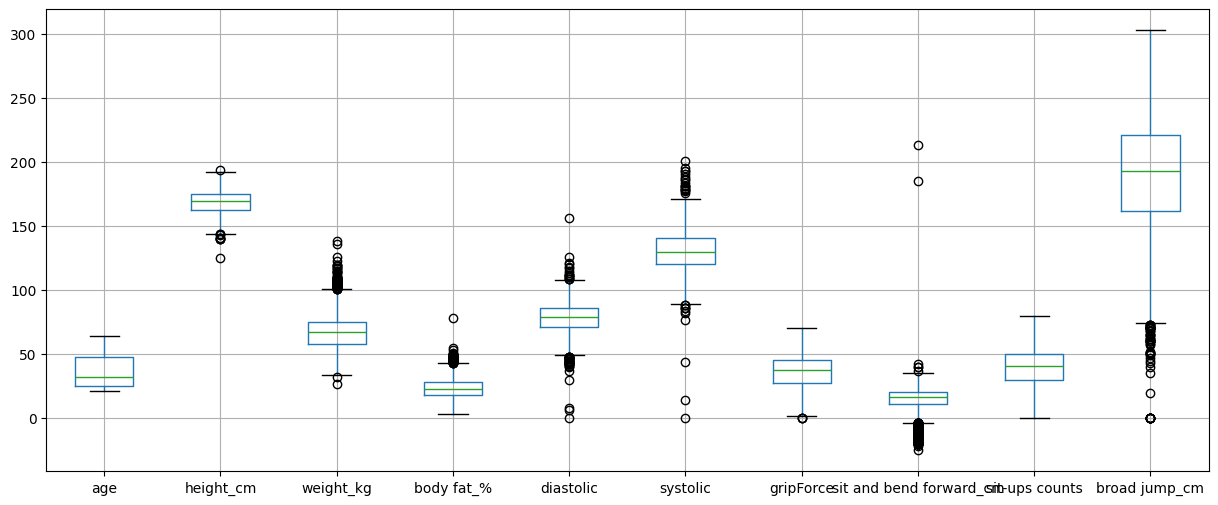

In [99]:
df.boxplot(figsize=(15,6))

Check Corelation

<Axes: >

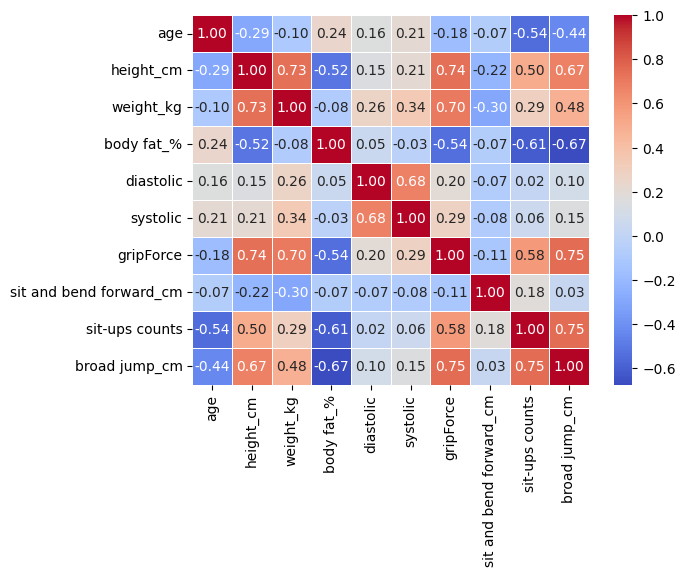

In [100]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

Multicollinearity Detection

In [101]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.drop(columns=['body fat_%'])
X = X.drop(columns=['class'])


X = pd.get_dummies(X, drop_first=True)
X = X.astype(float)

vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i)
              for i in range(X.shape[1])]

vif.sort_values(by="VIF", ascending=False)

,Feature,VIF
1,height_cm,218.936617
4,systolic,159.139617
8,broad jump_cm,105.184044
3,diastolic,100.998381
2,weight_kg,90.711102
5,gripForce,56.172999
7,sit-ups counts,25.904185
0,age,14.366331
9,gender_M,11.057001
6,sit and bend forward_cm,6.378819


### **Prepocessing Data**

Split X and Y

In [102]:
X = df.drop(columns=['body fat_%'])
y = df['body fat_%']

Encode Categorical Feature

In [103]:
X = pd.get_dummies(X, drop_first=True)
X = X.astype(float)

Make pipeline Linear Regression

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso

base_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=0.1))
])

### **Make Model**

In [105]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

Baseline Regression Linear

In [106]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
rmse_list = []
r2_list = []
mape_list = []

all_y_test = []
all_y_pred = []

for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Remove Outlier in data train use IQR
    Q1 = X_train.quantile(0.25)
    Q3 = X_train.quantile(0.75)
    IQR = Q3 - Q1

    mask = ~((X_train < (Q1 - 1.5 * IQR)) |
             (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

    X_train_clean = X_train[mask]
    y_train_clean = y_train[mask]


    base_pipeline.fit(X_train_clean, y_train_clean)

    y_pred = base_pipeline.predict(X_test)

    mae_list.append(mean_absolute_error(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_list.append(r2_score(y_test, y_pred))
    mape_list.append(mean_absolute_percentage_error(y_test, y_pred))

    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

print("MAE:", np.mean(mae_list))
print("RMSE:", np.mean(rmse_list))
print("R2:", np.mean(r2_list))
print(f"MAPE: {np.mean(mape_list) * 100:.2f}%")

MAE: 2.9154334799361545
RMSE: 3.7565600804359702
R2: 0.7319357965205059
MAPE: 14.51%


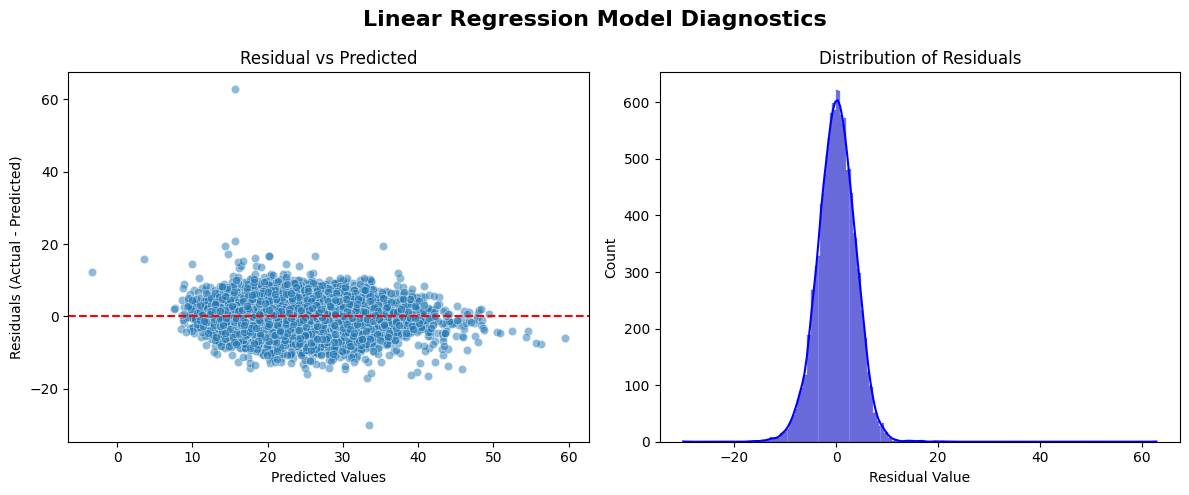

In [107]:
plt.figure(figsize=(12, 5))

plt.suptitle('Linear Regression Model Diagnostics', fontsize=16, fontweight='bold')
plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')


plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')

plt.tight_layout()
plt.show()

Ridge Regression

In [108]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
rmse_list = []
r2_list = []
mape_list = []

all_y_test = []
all_y_pred = []

for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Remove Outlier in data train use IQR
    Q1 = X_train.quantile(0.25)
    Q3 = X_train.quantile(0.75)
    IQR = Q3 - Q1

    mask = ~((X_train < (Q1 - 1.5 * IQR)) |
             (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

    X_train_clean = X_train[mask]
    y_train_clean = y_train[mask]


    ridge_pipe.fit(X_train_clean, y_train_clean)

    y_pred = ridge_pipe.predict(X_test)

    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

    mae_list.append(mean_absolute_error(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_list.append(r2_score(y_test, y_pred))
    mape_list.append(mean_absolute_percentage_error(y_test, y_pred))

all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

print("MAE:", np.mean(mae_list))
print("RMSE:", np.mean(rmse_list))
print("R2:", np.mean(r2_list))
print(f"MAPE: {np.mean(mape_list) * 100:.2f}%")

MAE: 2.9155182161464
RMSE: 3.75657816805669
R2: 0.731933404134107
MAPE: 14.51%


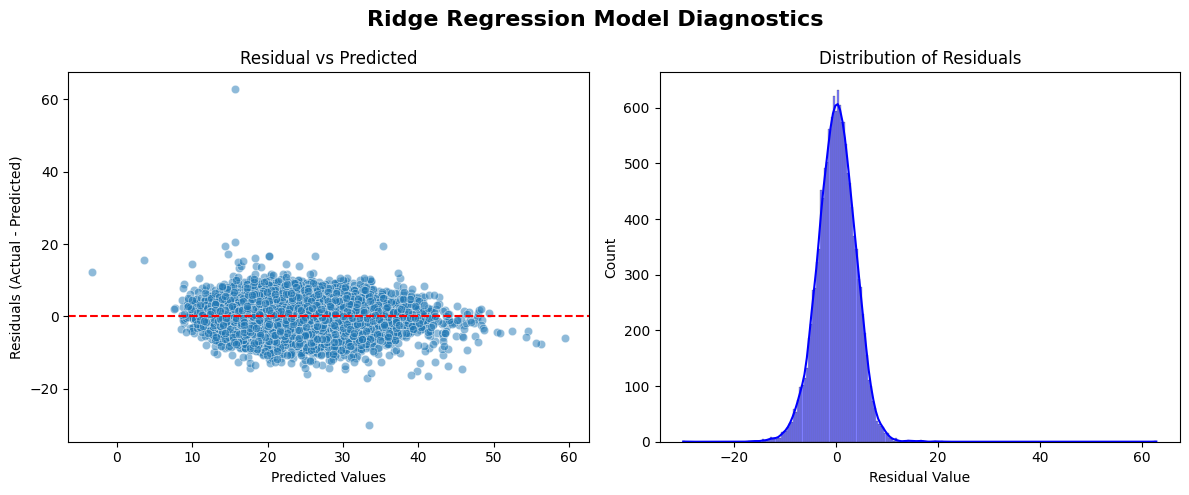

In [109]:
plt.figure(figsize=(12, 5))

plt.suptitle('Ridge Regression Model Diagnostics', fontsize=16, fontweight='bold')
plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')


plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')

plt.tight_layout()
plt.show()

Lasso Pipe

In [110]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
rmse_list = []
r2_list = []
mape_list = []

all_y_test = []
all_y_pred = []

for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Remove Outlier in data train use IQR
    Q1 = X_train.quantile(0.25)
    Q3 = X_train.quantile(0.75)
    IQR = Q3 - Q1

    mask = ~((X_train < (Q1 - 1.5 * IQR)) |
             (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

    X_train_clean = X_train[mask]
    y_train_clean = y_train[mask]


    lasso_pipe.fit(X_train_clean, y_train_clean)

    y_pred = lasso_pipe.predict(X_test)

    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

    mae_list.append(mean_absolute_error(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_list.append(r2_score(y_test, y_pred))
    mape_list.append(mean_absolute_percentage_error(y_test, y_pred))


all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

print("MAE:", np.mean(mae_list))
print("RMSE:", np.mean(rmse_list))
print("R2:", np.mean(r2_list))
print(f"MAPE: {np.mean(mape_list) * 100:.2f}%")

MAE: 2.9708434787306772
RMSE: 3.8120585717951947
R2: 0.7239359623310966
MAPE: 14.73%


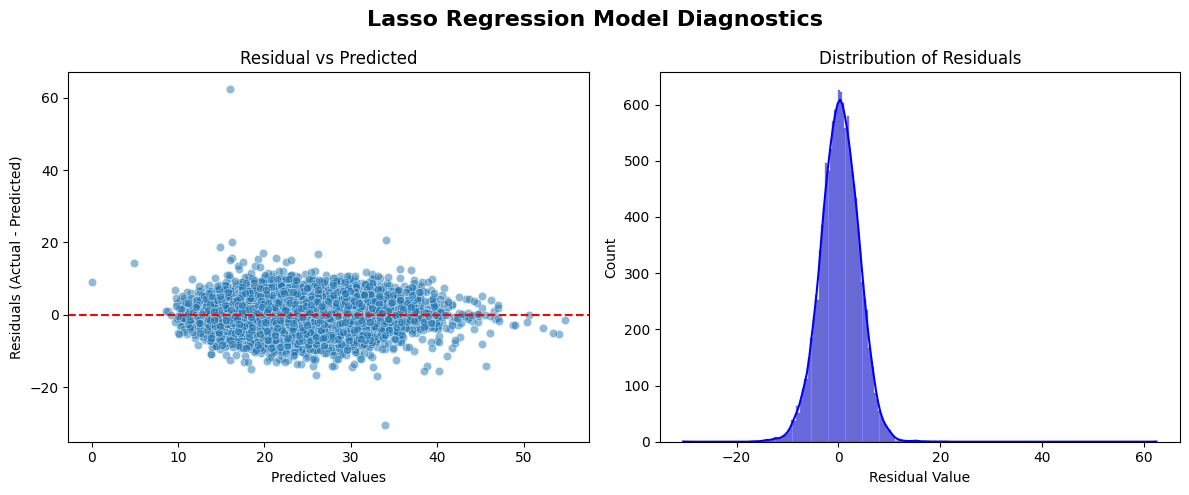

In [111]:
plt.figure(figsize=(12, 5))

plt.suptitle('Lasso Regression Model Diagnostics', fontsize=16, fontweight='bold')
plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')


plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')

plt.tight_layout()
plt.show()

### **Hyperparamter tuning Alpha**

Tuning Alpha Ridge

In [112]:
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

alphas = [0.01, 0.1, 1.0, 10.0, 100.0, 500.0]

best_mae = float('inf')
best_alpha = None
results = []

for a in alphas:
    # Update alpha pada model di dalam pipeline
    ridge_pipe.set_params(model__alpha=a)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    mae_fold = []
    rmse_fold = []
    r2_fold = []
    mape_fold = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        Q1 = X_train.quantile(0.25)
        Q3 = X_train.quantile(0.75)
        IQR = Q3 - Q1

        mask = ~((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

        X_train_clean = X_train[mask]
        y_train_clean = y_train[mask]

        ridge_pipe.fit(X_train_clean, y_train_clean)


        y_pred = ridge_pipe.predict(X_test)


        mae_fold.append(mean_absolute_error(y_test, y_pred))
        rmse_fold.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_fold.append(r2_score(y_test, y_pred))
        mape_fold.append(mean_absolute_percentage_error(y_test, y_pred))

    avg_mae = np.mean(mae_fold)
    avg_rmse = np.mean(rmse_fold)
    avg_r2 = np.mean(r2_fold)
    avg_mape = np.mean(mape_fold) * 100

    print(f"Alpha: {a:7} | MAE: {avg_mae} | R2: {avg_r2} | RMSE: {avg_rmse} | MAPE: {avg_mape:.2f}%" )


    if avg_mae < best_mae:
        best_mae = avg_mae
        best_alpha = a
        best_metrics = {'MAE': avg_mae, 'RMSE': avg_rmse, 'R2': avg_r2, 'MAPE': avg_mape}

print()
print("Best Alpha:")
print(f"Alpha        : {best_alpha}")
print(f"MAE          : {best_metrics['MAE']}")
print(f"RMSE         : {best_metrics['RMSE']}")
print(f"R2           : {best_metrics['R2']}")
print(f"MAPE         : {best_metrics['MAPE']:.2f}%")

Alpha:    0.01 | MAE: 2.915434326040799 | R2: 0.7319357743585898 | RMSE: 3.756560248995652 | MAPE: 14.51%
Alpha:     0.1 | MAE: 2.915441939878151 | R2: 0.7319355732967172 | RMSE: 3.756561777249966 | MAPE: 14.51%
Alpha:     1.0 | MAE: 2.9155182161464 | R2: 0.731933404134107 | RMSE: 3.75657816805669 | MAPE: 14.51%
Alpha:    10.0 | MAE: 2.9163455718775855 | R2: 0.7318961666872046 | RMSE: 3.756850702901019 | MAPE: 14.51%
Alpha:   100.0 | MAE: 2.9307686483287876 | R2: 0.7302322433401884 | RMSE: 3.768553783932009 | MAPE: 14.57%
Alpha:   500.0 | MAE: 3.0546936153763524 | R2: 0.7098184185929013 | RMSE: 3.907218203203402 | MAPE: 15.10%

Best Alpha:
Alpha        : 0.01
MAE          : 2.915434326040799
RMSE         : 3.756560248995652
R2           : 0.7319357743585898
MAPE         : 14.51%


Tuning Alpha Lasso

In [113]:
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

alphas = [0.01, 0.1, 1.0, 10.0, 100.0, 500.0]

best_mae = float('inf')
best_alpha = None
results = []

for a in alphas:
    lasso_pipe.set_params(model__alpha=a)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    mae_fold = []
    rmse_fold = []
    r2_fold = []
    mape_fold = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]


        Q1 = X_train.quantile(0.25)
        Q3 = X_train.quantile(0.75)
        IQR = Q3 - Q1


        mask = ~((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

        X_train_clean = X_train[mask]
        y_train_clean = y_train[mask]

        lasso_pipe.fit(X_train_clean, y_train_clean)


        y_pred = lasso_pipe.predict(X_test)


        mae_fold.append(mean_absolute_error(y_test, y_pred))
        rmse_fold.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_fold.append(r2_score(y_test, y_pred))
        mape_fold.append(mean_absolute_percentage_error(y_test, y_pred))


    avg_mae = np.mean(mae_fold)
    avg_rmse = np.mean(rmse_fold)
    avg_r2 = np.mean(r2_fold)
    avg_mape = np.mean(mape_fold) * 100

    print(f"Alpha: {a:7} | MAE: {avg_mae} | R2: {avg_r2} | RMSE: {avg_rmse} | MAPE: {avg_mape:.2f}%" )

    if avg_mae < best_mae:
        best_mae = avg_mae
        best_alpha = a
        best_metrics = {'MAE': avg_mae, 'RMSE': avg_rmse, 'R2': avg_r2, 'MAPE': avg_mape}

print()
print("Best Alpha:")
print(f"Alpha        : {best_alpha}")
print(f"MAE          : {best_metrics['MAE']}")
print(f"RMSE         : {best_metrics['RMSE']}")
print(f"R2           : {best_metrics['R2']}")
print(f"MAPE         : {best_metrics['MAPE']:.2f}%")

Alpha:    0.01 | MAE: 2.917414415030314 | R2: 0.7318441772826938 | RMSE: 3.757222789382068 | MAPE: 14.51%
Alpha:     0.1 | MAE: 2.9708434787306772 | R2: 0.7239359623310966 | RMSE: 3.8120585717951947 | MAPE: 14.73%
Alpha:     1.0 | MAE: 4.1259966631839635 | R2: 0.47649731553639263 | RMSE: 5.23206526215227 | MAPE: 20.24%
Alpha:    10.0 | MAE: 5.863676861070542 | R2: -0.026444410683235286 | RMSE: 7.350379389384317 | MAPE: 29.06%
Alpha:   100.0 | MAE: 5.863676861070542 | R2: -0.026444410683235286 | RMSE: 7.350379389384317 | MAPE: 29.06%
Alpha:   500.0 | MAE: 5.863676861070542 | R2: -0.026444410683235286 | RMSE: 7.350379389384317 | MAPE: 29.06%

Best Alpha:
Alpha        : 0.01
MAE          : 2.917414415030314
RMSE         : 3.757222789382068
R2           : 0.7318441772826938
MAPE         : 14.51%


# **Stress Test**

### **Noise Stress**

Regression Linear Baseline

In [114]:
base_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

In [115]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
noise_levels = [0, 0.05, 0.10, 0.20, 0.40]

results = {}

for noise_level in noise_levels:

    mae_list = []
    rmse_list = []
    r2_list = []
    mape_list = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Remove outlier with IQR
        Q1 = X_train.quantile(0.25)
        Q3 = X_train.quantile(0.75)
        IQR = Q3 - Q1

        mask = ~((X_train < (Q1 - 1.5 * IQR)) |
                 (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

        X_train_clean = X_train[mask]
        y_train_clean = y_train[mask]

        #Add noise in data test
        X_test_noisy = X_test.copy()
        noise = np.random.normal(0, noise_level, X_test.shape)
        X_test_noisy = X_test_noisy + noise

        base_pipeline.fit(X_train_clean, y_train_clean)

        y_pred = base_pipeline.predict(X_test_noisy)

        mae_list.append(mean_absolute_error(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_list.append(r2_score(y_test, y_pred))
        mape_list.append(mean_absolute_percentage_error(y_test, y_pred))

    results[noise_level] = {
        "MAE": f"{np.mean(mae_list)}",
        "RMSE": f"{np.mean(rmse_list)}",
        "R2": f"{np.mean(r2_list)}",
        "MAPE": f"{np.mean(mape_list) * 100:.2f}%"
    }


df_results = pd.DataFrame(results).T
df_results.index.name = 'Noise_Level'

for col in ['MAE', 'RMSE', 'R2']:
    df_results[col] = df_results[col].astype(float)

print("Linear Regression Noise Stress Results:")
display(df_results)

Linear Regression Noise Stress Results:


,MAE,RMSE,R2,MAPE
Noise_Level,,,,
0.00,2.915433,3.756560,0.731936,14.51%
0.05,2.924935,3.765646,0.730639,14.55%
0.10,2.938070,3.780874,0.728461,14.63%
0.20,3.029047,3.882372,0.713685,15.00%
0.40,3.334315,4.250753,0.656755,16.51%


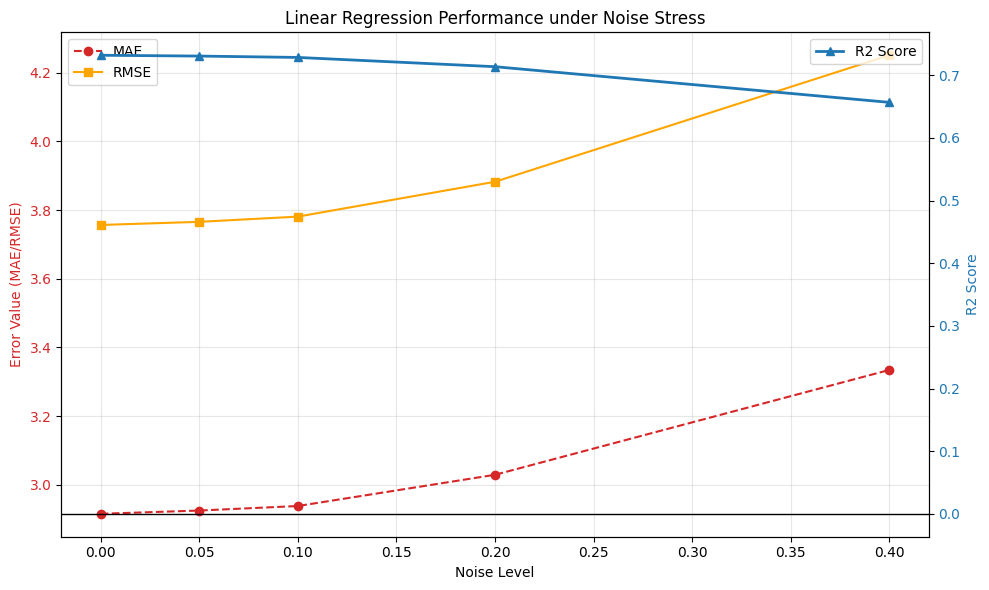

In [116]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Noise Level')
ax1.set_ylabel('Error Value (MAE/RMSE)', color='tab:red')
ax1.plot(df_results.index, df_results['MAE'], marker='o', label='MAE', color='tab:red', linestyle='--')
ax1.plot(df_results.index, df_results['RMSE'], marker='s', label='RMSE', color='orange')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score', color='tab:blue')
ax2.plot(df_results.index, df_results['R2'], marker='^', label='R2 Score', color='tab:blue', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2.axhline(0, color='black', linewidth=1, linestyle='-')

plt.title('Linear Regression Performance under Noise Stress')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

Ridge Regression Best Alpha

In [120]:
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=0.01))
])

In [121]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
noise_levels = [0, 0.05, 0.10, 0.20, 0.40]

results = {}

for noise_level in noise_levels:

    mae_list = []
    rmse_list = []
    r2_list = []
    mape_list = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Remove outlier with IQR
        Q1 = X_train.quantile(0.25)
        Q3 = X_train.quantile(0.75)
        IQR = Q3 - Q1

        mask = ~((X_train < (Q1 - 1.5 * IQR)) |
                 (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

        X_train_clean = X_train[mask]
        y_train_clean = y_train[mask]

        #Add noise in data test
        X_test_noisy = X_test.copy()
        noise = np.random.normal(0, noise_level, X_test.shape)
        X_test_noisy = X_test_noisy + noise

        ridge_pipe.fit(X_train_clean, y_train_clean)

        y_pred = ridge_pipe.predict(X_test_noisy)

        mae_list.append(mean_absolute_error(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_list.append(r2_score(y_test, y_pred))
        mape_list.append(mean_absolute_percentage_error(y_test, y_pred))

    results[noise_level] = {
        "MAE": f"{np.mean(mae_list)}",
        "RMSE": f"{np.mean(rmse_list)}",
        "R2": f"{np.mean(r2_list)}",
        "MAPE": f"{np.mean(mape_list) * 100:.2f}%"
    }


df_results = pd.DataFrame(results).T
df_results.index.name = 'Noise_Level'

for col in ['MAE', 'RMSE', 'R2']:
    df_results[col] = df_results[col].astype(float)

print("Ridge Regression Best Alpha (0.01) Noise Stress Results:")
display(df_results)

Ridge Regression Best Alpha (0.01) Noise Stress Results:


,MAE,RMSE,R2,MAPE
Noise_Level,,,,
0.00,2.915434,3.756560,0.731936,14.51%
0.05,2.923016,3.765446,0.730667,14.54%
0.10,2.946833,3.792695,0.726758,14.65%
0.20,3.027760,3.893147,0.712097,15.01%
0.40,3.363370,4.278662,0.652233,16.58%


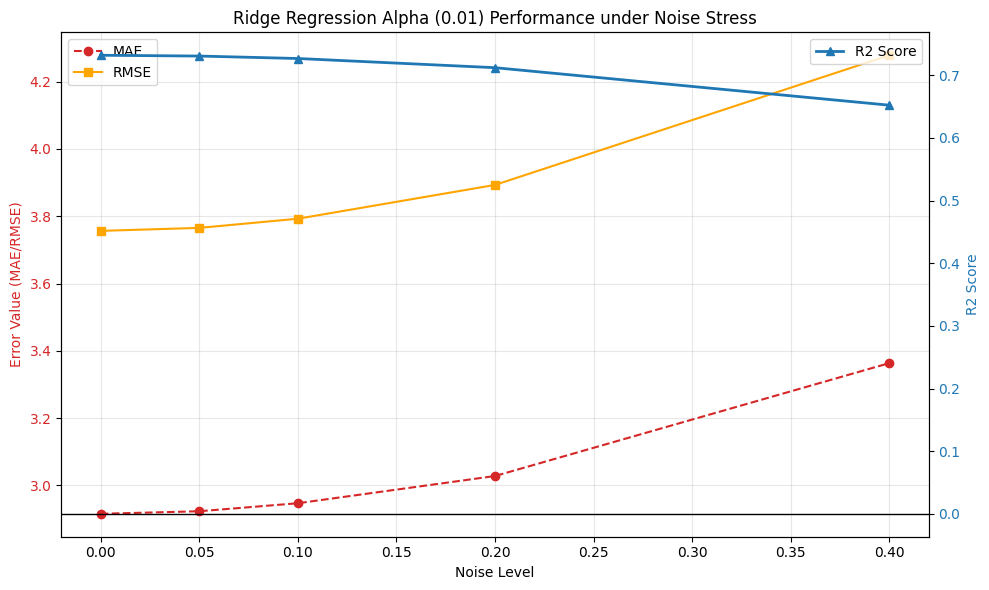

In [122]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Noise Level')
ax1.set_ylabel('Error Value (MAE/RMSE)', color='tab:red')
ax1.plot(df_results.index, df_results['MAE'], marker='o', label='MAE', color='tab:red', linestyle='--')
ax1.plot(df_results.index, df_results['RMSE'], marker='s', label='RMSE', color='orange')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score', color='tab:blue')
ax2.plot(df_results.index, df_results['R2'], marker='^', label='R2 Score', color='tab:blue', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2.axhline(0, color='black', linewidth=1, linestyle='-')

plt.title('Ridge Regression Alpha (0.01) Performance under Noise Stress')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

Lasso Regression Best Alpha (0.01)

In [123]:
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=0.01))
])

In [124]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
noise_levels = [0, 0.05, 0.10, 0.20, 0.40]

results = {}

for noise_level in noise_levels:

    mae_list = []
    rmse_list = []
    r2_list = []
    mape_list = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Remove outlier with IQR
        Q1 = X_train.quantile(0.25)
        Q3 = X_train.quantile(0.75)
        IQR = Q3 - Q1

        mask = ~((X_train < (Q1 - 1.5 * IQR)) |
                 (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

        X_train_clean = X_train[mask]
        y_train_clean = y_train[mask]

        #Add noise in data test
        X_test_noisy = X_test.copy()
        noise = np.random.normal(0, noise_level, X_test.shape)
        X_test_noisy = X_test_noisy + noise

        lasso_pipe.fit(X_train_clean, y_train_clean)

        y_pred = lasso_pipe.predict(X_test_noisy)

        mae_list.append(mean_absolute_error(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_list.append(r2_score(y_test, y_pred))
        mape_list.append(mean_absolute_percentage_error(y_test, y_pred))

    results[noise_level] = {
        "MAE": f"{np.mean(mae_list)}",
        "RMSE": f"{np.mean(rmse_list)}",
        "R2": f"{np.mean(r2_list)}",
        "MAPE": f"{np.mean(mape_list) * 100:.2f}%"
    }


df_results = pd.DataFrame(results).T
df_results.index.name = 'Noise_Level'

for col in ['MAE', 'RMSE', 'R2']:
    df_results[col] = df_results[col].astype(float)

print("Lasso Regression Best Alpha (0.01) Noise Stress Results:")
display(df_results)

Lasso Regression Best Alpha (0.01) Noise Stress Results:


,MAE,RMSE,R2,MAPE
Noise_Level,,,,
0.00,2.917414,3.757223,0.731844,14.51%
0.05,2.923565,3.766906,0.730459,14.54%
0.10,2.951049,3.795088,0.726411,14.68%
0.20,3.035153,3.898331,0.711332,15.08%
0.40,3.344227,4.273892,0.653005,16.55%


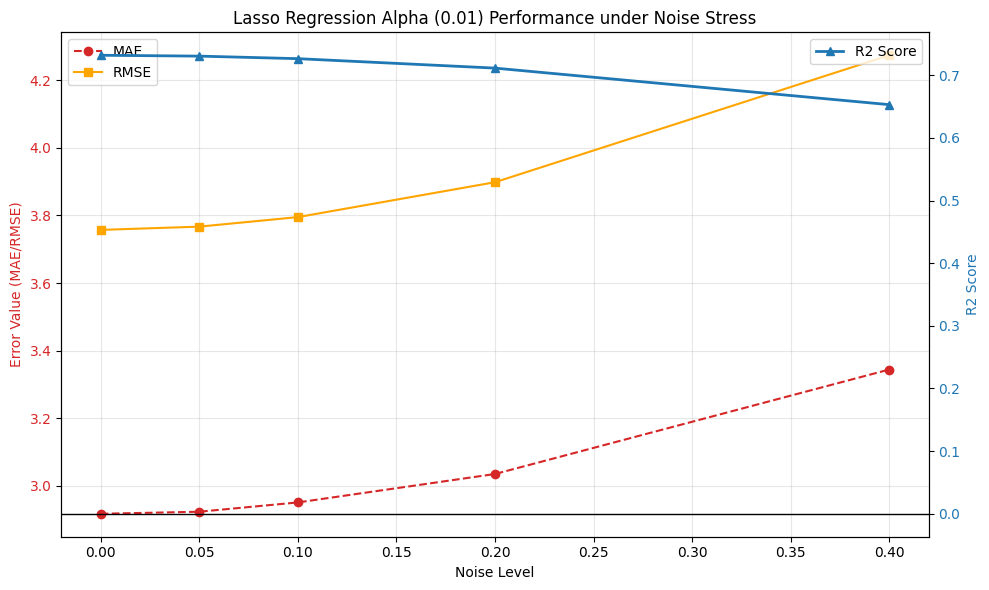

In [125]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Noise Level')
ax1.set_ylabel('Error Value (MAE/RMSE)', color='tab:red')
ax1.plot(df_results.index, df_results['MAE'], marker='o', label='MAE', color='tab:red', linestyle='--')
ax1.plot(df_results.index, df_results['RMSE'], marker='s', label='RMSE', color='orange')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score', color='tab:blue')
ax2.plot(df_results.index, df_results['R2'], marker='^', label='R2 Score', color='tab:blue', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2.axhline(0, color='black', linewidth=1, linestyle='-')

plt.title('Lasso Regression Alpha (0.01) Performance under Noise Stress')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

### **Outlier Stress**

In [126]:
def add_outliers(X, y, percentage):
    n_outliers = int(len(X) * percentage)

    if n_outliers == 0:
        return X.copy(), y.copy()

    outlier_features = X.mean() + 2 * X.std()
    outlier_target = y.mean() + 2 * y.std()


    X_new = pd.DataFrame(
        [outlier_features.values] * n_outliers,
        columns=X.columns
    ).astype(X.dtypes)


    y_new = pd.Series(
        [outlier_target] * n_outliers,
        name=y.name
    ).astype(y.dtype)


    X_out = pd.concat([X, X_new], ignore_index=True)
    y_out = pd.concat([y, y_new], ignore_index=True)

    return X_out, y_out

Linear Regression

In [127]:
base_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

In [128]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
percent_levels = [0, 0.05, 0.10, 0.20, 0.30]

results = {}

for percent_level in percent_levels:

    mae_list = []
    rmse_list = []
    r2_list = []
    mape_list = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Remove outlier with IQR
        Q1 = X_train.quantile(0.25)
        Q3 = X_train.quantile(0.75)
        IQR = Q3 - Q1

        mask = ~((X_train < (Q1 - 1.5 * IQR)) |
                 (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

        X_train_clean = X_train[mask]
        y_train_clean = y_train[mask]

        # Add outlier
        X_test_stress, y_test_stress = add_outliers(X_test, y_test, percentage=percent_level)

        base_pipeline.fit(X_train_clean, y_train_clean)

        y_pred = base_pipeline.predict(X_test_stress)

        mae_list.append(mean_absolute_error(y_test_stress, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test_stress, y_pred)))
        r2_list.append(r2_score(y_test_stress, y_pred))
        mape_list.append(mean_absolute_percentage_error(y_test_stress, y_pred))

    results[percent_level] = {
        "MAE": f"{np.mean(mae_list)}",
        "RMSE": f"{np.mean(rmse_list)}",
        "R2": f"{np.mean(r2_list)}",
        "MAPE": f"{np.mean(mape_list) * 100:.2f}%"
    }


df_results = pd.DataFrame(results).T
df_results.index.name = 'Outlier_Percent'

for col in ['MAE', 'RMSE', 'R2']:
    df_results[col] = df_results[col].astype(float)

print("Linear Regression Outlier Stress Results:")
display(df_results)

Linear Regression Outlier Stress Results:


,MAE,RMSE,R2,MAPE
Outlier_Percent,,,,
0.00,2.915433,3.756560,0.731936,14.51%
0.05,3.965507,6.579736,0.273869,16.97%
0.10,4.927578,8.367656,-0.074014,19.22%
0.20,6.611022,10.806385,-0.598610,23.17%
0.30,8.035297,12.503543,-1.009215,26.50%


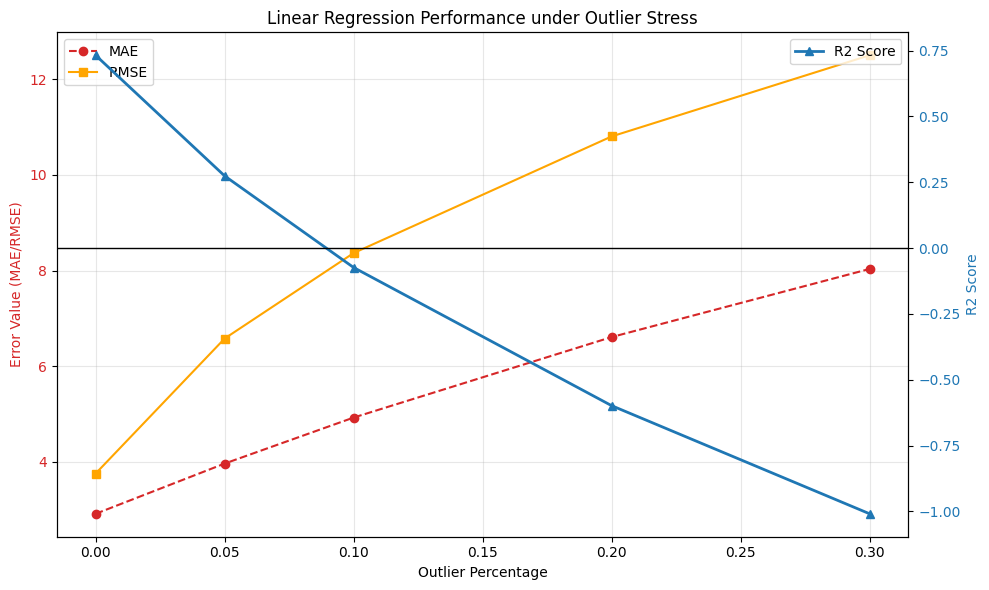

In [129]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Outlier Percentage')
ax1.set_ylabel('Error Value (MAE/RMSE)', color='tab:red')
ax1.plot(df_results.index, df_results['MAE'], marker='o', label='MAE', color='tab:red', linestyle='--')
ax1.plot(df_results.index, df_results['RMSE'], marker='s', label='RMSE', color='orange')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score', color='tab:blue')
ax2.plot(df_results.index, df_results['R2'], marker='^', label='R2 Score', color='tab:blue', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2.axhline(0, color='black', linewidth=1, linestyle='-')

plt.title('Linear Regression Performance under Outlier Stress')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

Ridge Regression Best Alpha

In [130]:
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=0.01))
])

In [131]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
percent_levels = [0, 0.05, 0.10, 0.20, 0.30]

results = {}

for percent_level in percent_levels:

    mae_list = []
    rmse_list = []
    r2_list = []
    mape_list = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Remove outlier with IQR
        Q1 = X_train.quantile(0.25)
        Q3 = X_train.quantile(0.75)
        IQR = Q3 - Q1

        mask = ~((X_train < (Q1 - 1.5 * IQR)) |
                 (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

        X_train_clean = X_train[mask]
        y_train_clean = y_train[mask]

        # Add outlier
        X_test_stress, y_test_stress = add_outliers(X_test, y_test, percentage=percent_level)

        ridge_pipe.fit(X_train_clean, y_train_clean)

        y_pred = ridge_pipe.predict(X_test_stress)

        mae_list.append(mean_absolute_error(y_test_stress, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test_stress, y_pred)))
        r2_list.append(r2_score(y_test_stress, y_pred))
        mape_list.append(mean_absolute_percentage_error(y_test_stress, y_pred))

    results[percent_level] = {
        "MAE": f"{np.mean(mae_list)}",
        "RMSE": f"{np.mean(rmse_list)}",
        "R2": f"{np.mean(r2_list)}",
        "MAPE": f"{np.mean(mape_list) * 100:.2f}%"
    }

df_results = pd.DataFrame(results).T
df_results.index.name = 'Outlier_Percent'

for col in ['MAE', 'RMSE', 'R2']:
    df_results[col] = df_results[col].astype(float)

print("Table Ridge Regression Best Alpha (0.01) Outlier Stress Results:")
display(df_results)

Table Ridge Regression Best Alpha (0.01) Outlier Stress Results:


,MAE,RMSE,R2,MAPE
Outlier_Percent,,,,
0.00,2.915434,3.756560,0.731936,14.51%
0.05,3.965506,6.579729,0.273870,16.97%
0.10,4.927575,8.367646,-0.074012,19.22%
0.20,6.611017,10.806371,-0.598606,23.17%
0.30,8.035289,12.503525,-1.009210,26.50%


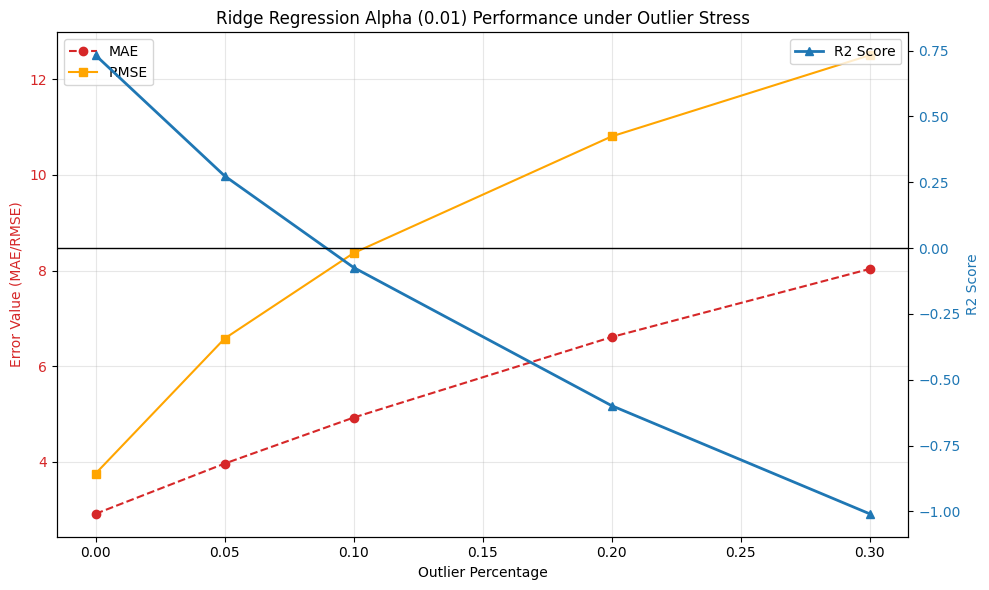

In [132]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Outlier Percentage')
ax1.set_ylabel('Error Value (MAE/RMSE)', color='tab:red')
ax1.plot(df_results.index, df_results['MAE'], marker='o', label='MAE', color='tab:red', linestyle='--')
ax1.plot(df_results.index, df_results['RMSE'], marker='s', label='RMSE', color='orange')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score', color='tab:blue')
ax2.plot(df_results.index, df_results['R2'], marker='^', label='R2 Score', color='tab:blue', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2.axhline(0, color='black', linewidth=1, linestyle='-')

plt.title('Ridge Regression Alpha (0.01) Performance under Outlier Stress')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

Lasso Regression Best Alpha

In [133]:
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=0.01))
])

In [134]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
percent_levels = [0, 0.05, 0.10, 0.20, 0.30]

results = {}

for percent_level in percent_levels:

    mae_list = []
    rmse_list = []
    r2_list = []
    mape_list = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Remove outlier with IQR
        Q1 = X_train.quantile(0.25)
        Q3 = X_train.quantile(0.75)
        IQR = Q3 - Q1

        mask = ~((X_train < (Q1 - 1.5 * IQR)) |
                 (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

        X_train_clean = X_train[mask]
        y_train_clean = y_train[mask]

        # Add outlier
        X_test_stress, y_test_stress = add_outliers(X_test, y_test, percentage=percent_level)

        lasso_pipe.fit(X_train_clean, y_train_clean)

        y_pred = lasso_pipe.predict(X_test_stress)

        mae_list.append(mean_absolute_error(y_test_stress, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test_stress, y_pred)))
        r2_list.append(r2_score(y_test_stress, y_pred))
        mape_list.append(mean_absolute_percentage_error(y_test_stress, y_pred))

    results[percent_level] = {
        "MAE": f"{np.mean(mae_list)}",
        "RMSE": f"{np.mean(rmse_list)}",
        "R2": f"{np.mean(r2_list)}",
        "MAPE": f"{np.mean(mape_list) * 100:.2f}%"
    }

df_results = pd.DataFrame(results).T
df_results.index.name = 'Outlier_Percent'

for col in ['MAE', 'RMSE', 'R2']:
    df_results[col] = df_results[col].astype(float)

print("Lasso Regression Best Alpha(0.01) Outlier Stress Results:")
display(df_results)

Lasso Regression Best Alpha(0.01) Outlier Stress Results:


,MAE,RMSE,R2,MAPE
Outlier_Percent,,,,
0.00,2.917414,3.757223,0.731844,14.51%
0.05,3.961191,6.556349,0.279039,16.96%
0.10,4.917492,8.332190,-0.064887,19.20%
0.20,6.590841,10.755794,-0.583598,23.11%
0.30,8.006575,12.442908,-0.989667,26.43%


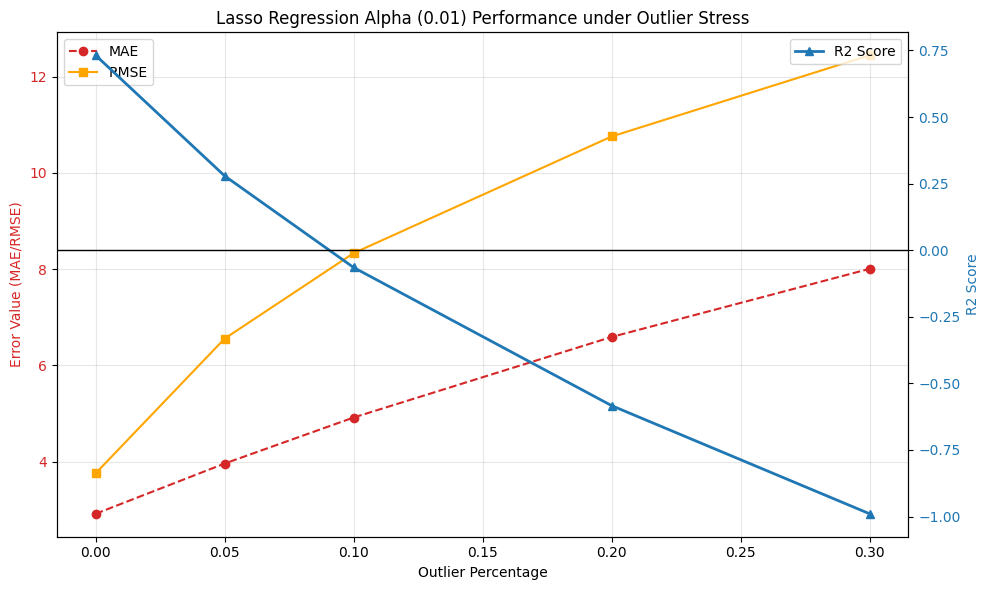

In [135]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Outlier Percentage')
ax1.set_ylabel('Error Value (MAE/RMSE)', color='tab:red')
ax1.plot(df_results.index, df_results['MAE'], marker='o', label='MAE', color='tab:red', linestyle='--')
ax1.plot(df_results.index, df_results['RMSE'], marker='s', label='RMSE', color='orange')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score', color='tab:blue')
ax2.plot(df_results.index, df_results['R2'], marker='^', label='R2 Score', color='tab:blue', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2.axhline(0, color='black', linewidth=1, linestyle='-')

plt.title('Lasso Regression Alpha (0.01) Performance under Outlier Stress')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

## **Distribution Shift**

## **Covariate Shift**

Linear Regression

In [136]:
base_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

In [137]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

shift_factors = [0, 0.5, 1.0, 1.5, 2.0]

results = {}

for shift in shift_factors:

    mae_list = []
    rmse_list = []
    r2_list = []
    mape_list = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Remove outlier with IQR
        Q1 = X_train.quantile(0.25)
        Q3 = X_train.quantile(0.75)
        IQR = Q3 - Q1

        mask = ~((X_train < (Q1 - 1.5 * IQR)) |
                 (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

        X_train_clean = X_train[mask]
        y_train_clean = y_train[mask]


        X_test_shifted = X_test + (shift * X_train_clean.std())


        base_pipeline.fit(X_train_clean, y_train_clean)

        y_pred = base_pipeline.predict(X_test_shifted)

        mae_list.append(mean_absolute_error(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_list.append(r2_score(y_test, y_pred))
        mape_list.append(mean_absolute_percentage_error(y_test, y_pred))

    results[shift] = {
        "MAE": f"{np.mean(mae_list)}",
        "RMSE": f"{np.mean(rmse_list)}",
        "R2": f"{np.mean(r2_list)}",
        "MAPE": f"{np.mean(mape_list) * 100:.2f}%"
    }

df_results = pd.DataFrame(results).T
df_results.index.name = 'Shift_Factor'

for col in ['MAE', 'RMSE', 'R2']:
    df_results[col] = df_results[col].astype(float)

print("Linear Regression Covariate Shift Results:")
display(df_results)

Linear Regression Covariate Shift Results:


,MAE,RMSE,R2,MAPE
Shift_Factor,,,,
0.0,2.915433,3.756560,0.731936,14.51%
0.5,3.736988,4.641295,0.590514,16.60%
1.0,5.665740,6.555483,0.181224,24.66%
1.5,8.091622,8.854341,-0.495936,35.79%
2.0,10.680798,11.306114,-1.440964,48.07%


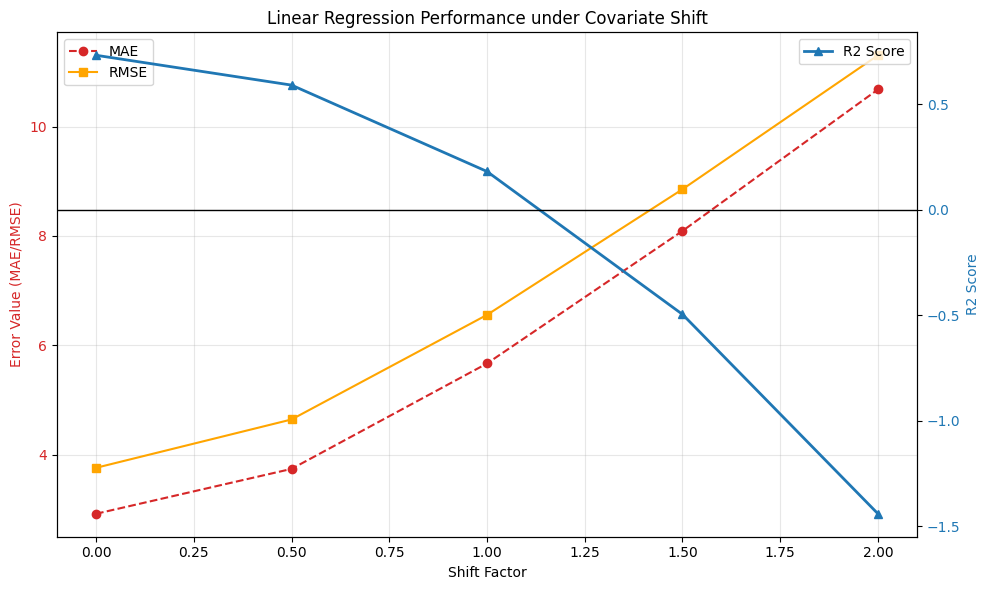

In [138]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Shift Factor')
ax1.set_ylabel('Error Value (MAE/RMSE)', color='tab:red')
ax1.plot(df_results.index, df_results['MAE'], marker='o', label='MAE', color='tab:red', linestyle='--')
ax1.plot(df_results.index, df_results['RMSE'], marker='s', label='RMSE', color='orange')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score', color='tab:blue')
ax2.plot(df_results.index, df_results['R2'], marker='^', label='R2 Score', color='tab:blue', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2.axhline(0, color='black', linewidth=1, linestyle='-')

plt.title('Linear Regression Performance under Covariate Shift')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

Ridge Regression Best Alpha

In [139]:
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=0.01))
])

In [140]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

shift_factors = [0, 0.5, 1.0, 1.5, 2.0]

results = {}

for shift in shift_factors:

    mae_list = []
    rmse_list = []
    r2_list = []
    mape_list = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Remove outlier with IQR
        Q1 = X_train.quantile(0.25)
        Q3 = X_train.quantile(0.75)
        IQR = Q3 - Q1

        mask = ~((X_train < (Q1 - 1.5 * IQR)) |
                 (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

        X_train_clean = X_train[mask]
        y_train_clean = y_train[mask]


        X_test_shifted = X_test + (shift * X_train_clean.std())


        ridge_pipe.fit(X_train_clean, y_train_clean)

        y_pred = ridge_pipe.predict(X_test_shifted)

        mae_list.append(mean_absolute_error(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_list.append(r2_score(y_test, y_pred))
        mape_list.append(mean_absolute_percentage_error(y_test, y_pred))

    results[shift] = {
        "MAE": f"{np.mean(mae_list)}",
        "RMSE": f"{np.mean(rmse_list)}",
        "R2": f"{np.mean(r2_list)}",
        "MAPE": f"{np.mean(mape_list) * 100:.2f}%"
    }

df_results = pd.DataFrame(results).T
df_results.index.name = 'Shift_Factor'

for col in ['MAE', 'RMSE', 'R2']:
    df_results[col] = df_results[col].astype(float)

print("Ridge Regression Best Aplha (0.01) Covariate Shift Results:")
display(df_results)

Ridge Regression Best Aplha (0.01) Covariate Shift Results:


,MAE,RMSE,R2,MAPE
Shift_Factor,,,,
0.0,2.915434,3.756560,0.731936,14.51%
0.5,3.736986,4.641293,0.590515,16.60%
1.0,5.665726,6.555470,0.181227,24.66%
1.5,8.091594,8.854315,-0.495927,35.79%
2.0,10.680756,11.306075,-1.440947,48.07%


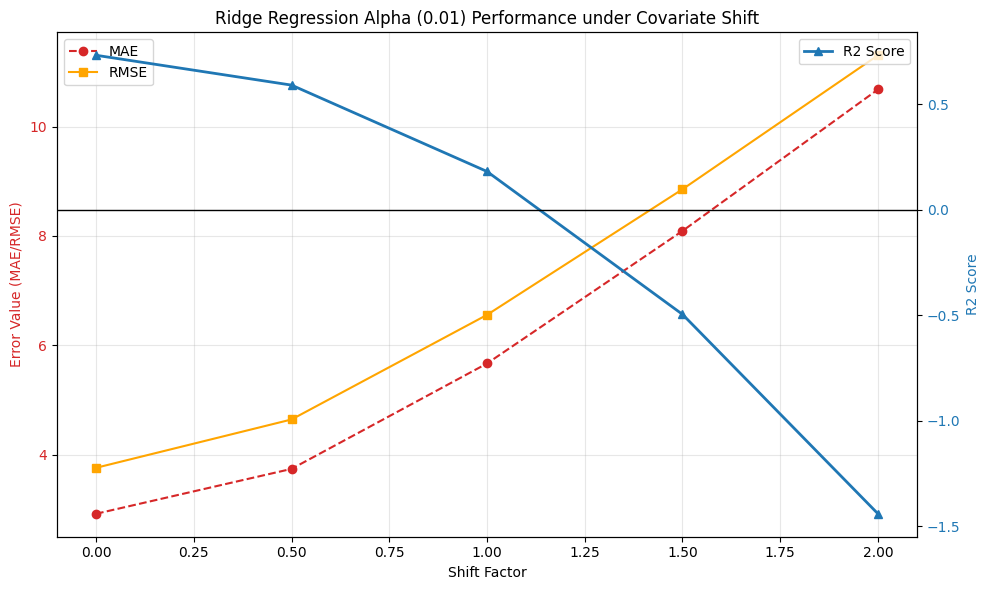

In [141]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Shift Factor')
ax1.set_ylabel('Error Value (MAE/RMSE)', color='tab:red')
ax1.plot(df_results.index, df_results['MAE'], marker='o', label='MAE', color='tab:red', linestyle='--')
ax1.plot(df_results.index, df_results['RMSE'], marker='s', label='RMSE', color='orange')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score', color='tab:blue')
ax2.plot(df_results.index, df_results['R2'], marker='^', label='R2 Score', color='tab:blue', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2.axhline(0, color='black', linewidth=1, linestyle='-')

plt.title('Ridge Regression Alpha (0.01) Performance under Covariate Shift')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

Lasso Regression Best Alpha

In [142]:
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=0.01))
])

In [143]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

shift_factors = [0, 0.5, 1.0, 1.5, 2.0]

results = {}

for shift in shift_factors:

    mae_list = []
    rmse_list = []
    r2_list = []
    mape_list = []

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Remove outlier with IQR
        Q1 = X_train.quantile(0.25)
        Q3 = X_train.quantile(0.75)
        IQR = Q3 - Q1

        mask = ~((X_train < (Q1 - 1.5 * IQR)) |
                 (X_train > (Q3 + 1.5 * IQR))).any(axis=1)

        X_train_clean = X_train[mask]
        y_train_clean = y_train[mask]


        X_test_shifted = X_test + (shift * X_train_clean.std())


        lasso_pipe.fit(X_train_clean, y_train_clean)

        y_pred = lasso_pipe.predict(X_test_shifted)

        mae_list.append(mean_absolute_error(y_test, y_pred))
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_list.append(r2_score(y_test, y_pred))
        mape_list.append(mean_absolute_percentage_error(y_test, y_pred))

    results[shift] = {
        "MAE": f"{np.mean(mae_list)}",
        "RMSE": f"{np.mean(rmse_list)}",
        "R2": f"{np.mean(r2_list)}",
        "MAPE": f"{np.mean(mape_list) * 100:.2f}%"
    }

df_results = pd.DataFrame(results).T
df_results.index.name = 'Shift_Factor'

for col in ['MAE', 'RMSE', 'R2']:
    df_results[col] = df_results[col].astype(float)

print("Lasso Regression Best Aplha (0.01) Covariate Shift Results:")
display(df_results)

Lasso Regression Best Aplha (0.01) Covariate Shift Results:


,MAE,RMSE,R2,MAPE
Shift_Factor,,,,
0.0,2.917414,3.757223,0.731844,14.51%
0.5,3.727546,4.631663,0.592193,16.54%
1.0,5.619220,6.511538,0.192191,24.40%
1.5,8.004157,8.772306,-0.468161,35.33%
2.0,10.554322,11.185849,-1.388864,47.41%


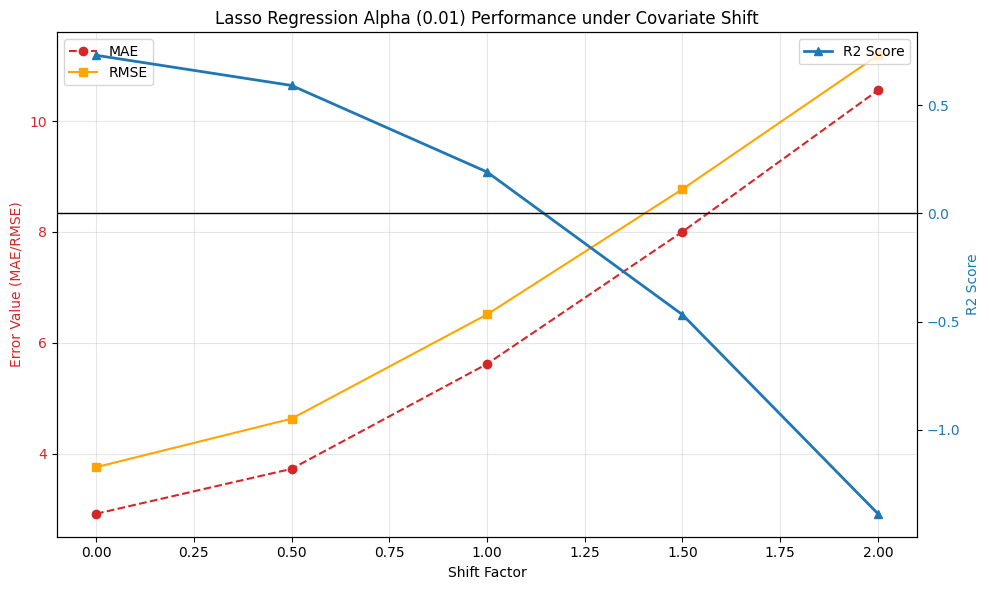

In [144]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Shift Factor')
ax1.set_ylabel('Error Value (MAE/RMSE)', color='tab:red')
ax1.plot(df_results.index, df_results['MAE'], marker='o', label='MAE', color='tab:red', linestyle='--')
ax1.plot(df_results.index, df_results['RMSE'], marker='s', label='RMSE', color='orange')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score', color='tab:blue')
ax2.plot(df_results.index, df_results['R2'], marker='^', label='R2 Score', color='tab:blue', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2.axhline(0, color='black', linewidth=1, linestyle='-')

plt.title('Lasso Regression Alpha (0.01) Performance under Covariate Shift')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()